In [1]:
from sklearn.linear_model import (
    LinearRegression,
    RidgeCV,
    BayesianRidge,
    Ridge,
    ElasticNetCV,
    ElasticNet,
    Lasso,
    LassoCV,
    LarsCV,
    LassoLarsCV,
    SGDRegressor,
    TheilSenRegressor,
    RANSACRegressor,
)
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, RepeatedKFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

INPUT_PATH = Path("/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
OUTPUT_PATH = Path("/mnt/storage_dimm2/kaggle_output/commonlitreadabilityprize")

In [25]:
# model_folders = [
#     # complex-heron-of-science - roberta-base
#     "20210609-171109",
#     "20210609-174639",
#     "20210609-182121",
#     "20210609-192843",
#     "20210609-200242",
#     # impetuous-marvellous-cockle - roberta-large
#     "20210608-233655",
#     "20210609-004922",
#     "20210609-020213",
#     "20210609-205046",
#     "20210609-220344",
#     # zippy-caped-leech - albert-large
#     "20210609-125306",
#     "20210609-141352",
#     "20210609-154233",
#     "20210610-000227",
#     "20210610-013100",
#     # armored-cobalt-crow - distill roberta
#     "20210610-074205",
#     "20210610-080716",
#     "20210610-083206",
#     "20210610-085718",
#     "20210610-093912",
#     # big-slug-of-tranquility - funnel transformer
#     "20210610-100607",
#     "20210610-111551",
#     "20210610-122301",
#     "20210610-133140",
#     "20210610-144044",
#     # nocturnal-winged-lionfish - bert-base-uncased
#     "20210610-184414",
#     "20210610-191826",
#     "20210610-195230",
#     "20210610-202640",
#     # adaptable-scallop-of-anger - roberta-base (hidden)
#     "20210610-222705",
#     "20210610-230256",
#     "20210610-233847",
#     "20210611-001430",
#     "20210611-005055",
#     # fluffy-dandelion-skua - roberta-large (hidden)
#     "20210611-012655",
#     "20210611-024254",
#     "20210611-035830",
#     "20210611-051501",
#     "20210611-063430",
#     # gregarious-classic-yak - albert-large (hidden)
#     "20210611-080150",
#     "20210611-092625",
#     "20210611-105105",
#     "20210611-121556",
#     "20210611-134040",
#     # serious-outrageous-caribou - deberta-base
#     "20210611-151313",
#     "20210611-155942",  # This seed seems amazing
#     "20210611-164611",
#     "20210611-173302",
#     "20210611-182030",
#     # ostrich-of-abstract-art - deberta-large
#     "20210611-191919",
#     "20210611-212749",
#     "20210611-233646",
#     "20210612-014457",
#     "20210612-035134",
# ]

model_folders = [
    # cherubic-nifty-serval - deberta-large
    "20210614-173633",
#     "20210614-203831",
    "20210614-234025",
    "20210615-024138",
    "20210615-054256",
    # scrupulous-mink-of-amplitude - deberta-base
    "20210615-084357",
    "20210615-094729",
    "20210615-105329",
    "20210615-120001",
    "20210615-130640",
    # notorious-sticky-gibbon - roberta-base (with hidden)
    "20210615-220146",
    "20210615-225055",
    "20210615-234038",
    "20210616-003038",
    "20210616-012048",
    # fortunate-cherry-mandrill - roberta-large
    "20210616-021135",
    "20210616-041221",
    "20210616-060255",
    "20210616-075451",
    "20210616-094506",
    # mottled-certain-caracal - distilroberta-base
    "20210616-113626",
    "20210616-121203",
    "20210616-124738",
    "20210616-132341",
    "20210616-140300",
    # aspiring-classic-pegasus - funnel
    "20210617-083847", 
    "20210617-102611", 
    "20210617-120949", 
    "20210617-135233", 
    "20210617-153459", 
    # silver-bumblebee-of-attack - roberta-base
    "20210617-223340",
    "20210617-232650",
    "20210618-002022",
    "20210618-011405",
    "20210618-020751",
    # sloppy-resourceful-tanuki - albert-large
    "20210617-225903",
    "20210618-010302",
    "20210618-030706",
    "20210618-051049",
    "20210618-071437",
    # rustling-quirky-mastodon - bert-base-uncased
    "20210618-082756",
    "20210618-092115",
    "20210618-100526",
    "20210618-105909",
    "20210618-115253",
    # perky-defiant-husky - bert-large-uncased
    "20210618-124637",
    "20210618-144213",
    "20210618-163942",
    "20210618-183719",
    "20210618-203441",
    # gregarious-brass-perch - bart-base
    "20210618-223208",
    "20210618-233614",
    "20210619-004022",
    "20210619-014809",
    "20210619-025421",
    # military-firefly-of-apotheosis - bart-large
    "20210619-035747",
    "20210619-064351",
    "20210619-093050",
    "20210619-121916",
    "20210619-150740",
    # eccentric-lemur-of-tenacity - sentence-transformers/LaBSE
    "20210622-152356",
    "20210622-161822",
    "20210622-171312",
    "20210622-181238",
    "20210622-191326",
    # valiant-chameleon-of-chaos - sentence-transformers/bert-base-nli-cls-token
    "20210622-165808",
    "20210622-174555",
    "20210622-183427",
    "20210622-192221",
    "20210622-201127",
]

print(len(model_folders))

dataset_paths = [OUTPUT_PATH / f for f in model_folders]

69


In [26]:
mpaths, oof_paths = [], []
for p in dataset_paths:
    mpaths.append(sorted(list(p.glob(f"*/*/*.ckpt"))))
    oof_paths.extend(sorted(list(p.glob(f"*.csv"))))
    
len(model_folders), len(oof_paths)

(69, 69)

In [27]:
oofs = pd.read_csv(INPUT_PATH / "train.csv", usecols=["id", "target", "standard_error"]).sort_values(
        by="id"
    )
for i, (p, f) in enumerate(zip(oof_paths, model_folders)):
    x = pd.read_csv(p).sort_values(by="id")
    oofs[f] = x["prediction"].values

# pred_cols = [f"model_{i}" for i in range(len(mpaths))]
pred_cols = model_folders

print(len(pred_cols))
    
oofs.head()

69


,id,target,standard_error,20210614-173633,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,20210615-105329,...,20210622-152356,20210622-161822,20210622-171312,20210622-181238,20210622-191326,20210622-165808,20210622-174555,20210622-183427,20210622-192221,20210622-201127
1279,000accf7e,-2.002055,0.497274,-2.174165,-2.451190,-2.505858,-2.490587,-2.264506,-2.664520,-2.577108,...,-2.301096,-2.218182,-2.455187,-2.704325,-2.824249,-2.358142,-2.287553,-2.408700,-2.273954,-2.538192
2185,001ef05a9,0.841000,0.492411,0.669889,0.472606,0.514734,0.493645,0.528904,0.495011,0.183860,...,0.383570,0.278789,0.093302,0.155898,0.321397,0.376842,0.764521,0.658732,0.437012,0.608306
332,00589d631,-2.195109,0.520239,-1.908255,-2.064695,-2.545308,-2.129548,-2.160540,-2.234235,-2.303517,...,-1.815974,-2.159087,-1.882258,-1.806120,-2.275727,-1.587003,-2.128695,-1.960583,-1.843070,-1.971397
72,0060c36b9,-1.333456,0.492384,-1.098570,-1.161226,-1.260594,-1.139692,-0.983574,-1.220255,-1.124083,...,-1.085744,-1.186338,-1.131350,-1.068403,-1.120813,-1.025191,-0.944617,-0.876536,-0.884135,-0.993464
2694,00d4d251d,0.088764,0.463817,-0.226934,-0.219147,-0.192564,0.082993,-0.454333,-0.133543,-0.273784,...,-0.049581,-0.149926,-0.216903,0.055648,0.044118,-0.136744,-0.096812,-0.485419,-0.271610,-0.180152


In [28]:
oofs.describe()

,target,standard_error,20210614-173633,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,20210615-105329,20210615-120001,...,20210622-152356,20210622-161822,20210622-171312,20210622-181238,20210622-191326,20210622-165808,20210622-174555,20210622-183427,20210622-192221,20210622-201127
count,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,...,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000
mean,-0.959319,0.491435,-0.948092,-0.936123,-0.968496,-0.958907,-0.891844,-0.910382,-0.932254,-0.873602,...,-0.893504,-0.930947,-0.935697,-0.930612,-0.945397,-0.875725,-0.867263,-0.916098,-0.922607,-0.906896
std,1.033579,0.034818,0.912312,0.913707,0.930968,0.905059,0.907261,0.927470,0.911461,0.905666,...,0.917795,0.883457,0.882028,0.929505,0.897549,0.895349,0.912479,0.909412,0.874168,0.879002
min,-3.676268,0.000000,-3.560785,-3.732013,-3.534283,-3.483280,-3.612729,-3.607502,-3.599687,-3.633023,...,-3.436680,-3.326350,-3.448749,-3.328314,-3.481294,-3.380171,-3.294784,-3.630807,-3.322556,-3.512614
25%,-1.690320,0.468543,-1.613250,-1.616401,-1.659845,-1.625832,-1.550567,-1.581456,-1.592230,-1.532337,...,-1.554786,-1.577877,-1.563907,-1.626398,-1.600115,-1.531903,-1.526976,-1.558302,-1.564922,-1.550203
50%,-0.912190,0.484721,-0.900925,-0.904669,-0.926716,-0.913854,-0.845645,-0.853657,-0.858941,-0.827258,...,-0.821609,-0.876551,-0.851236,-0.858103,-0.865695,-0.815483,-0.806504,-0.851151,-0.849488,-0.843045
75%,-0.202540,0.506268,-0.242909,-0.232878,-0.260776,-0.254002,-0.191775,-0.206128,-0.229850,-0.171765,...,-0.196081,-0.237076,-0.265601,-0.198050,-0.260768,-0.179170,-0.159501,-0.233472,-0.246678,-0.213155
max,1.711390,0.649671,1.249225,1.232993,1.288711,1.167053,1.241939,1.432130,1.164523,1.428027,...,1.220793,1.198255,1.352262,1.323812,1.293701,1.218863,1.373409,1.244158,1.119674,1.307637


In [29]:
# oofs.loc[:, pred_cols].clip(oofs["target"].min(), oofs["target"].max(), inplace=True)

In [30]:
reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000), normalize=False)
reg.fit(oofs[pred_cols], oofs["target"])
print(f"Best score: {np.sqrt(-reg.best_score_):0.5f}. Alpha {reg.alpha_}")
reg.coef_

Best score: 0.45310. Alpha 100.0


array([ 0.07693187,  0.05473947,  0.0311012 ,  0.04629127, -0.00946972,
        0.06980849, -0.02032823,  0.01355776,  0.00282788,  0.0213994 ,
        0.03526425,  0.038662  , -0.02675388,  0.02477635,  0.01629333,
        0.09295597,  0.06612545,  0.05660214,  0.04691014,  0.03529006,
       -0.0206085 ,  0.02058155,  0.05308793, -0.00254516,  0.03232767,
        0.07188501,  0.06638274,  0.09952667,  0.01822891,  0.02264425,
        0.03190747,  0.01418935, -0.00408689, -0.01586601, -0.00961604,
        0.04679783,  0.05022922,  0.02148138, -0.01323999,  0.01537622,
        0.02558618, -0.00218922,  0.02566216, -0.01470804,  0.00744406,
        0.00486276, -0.00351111, -0.02011741, -0.0145257 ,  0.04033509,
       -0.00981263, -0.08579986, -0.02371623, -0.00126307, -0.07334708,
       -0.02167184,  0.0151274 , -0.01344225, -0.00376099,  0.03359482,
        0.02633483,  0.0187744 , -0.02929953,  0.02497005, -0.0282889 ,
       -0.01032366, -0.02355825,  0.01117318,  0.00672191])

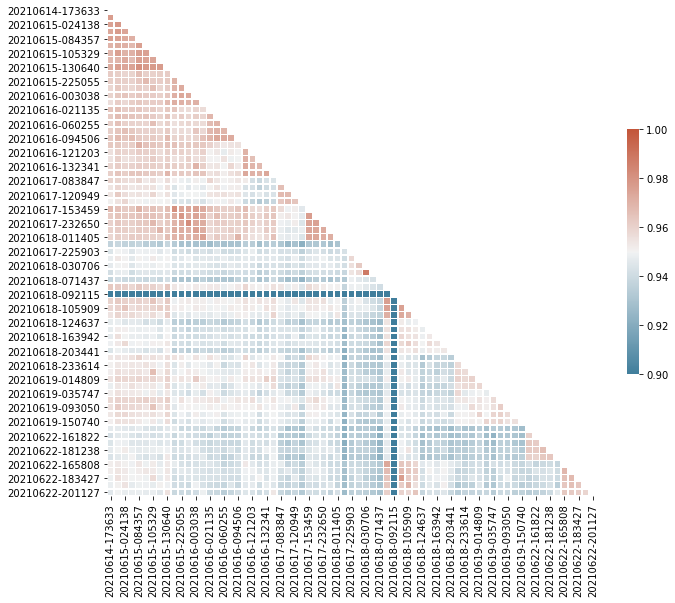

In [31]:
corr = oofs[pred_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.9, vmax=1.0, # center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

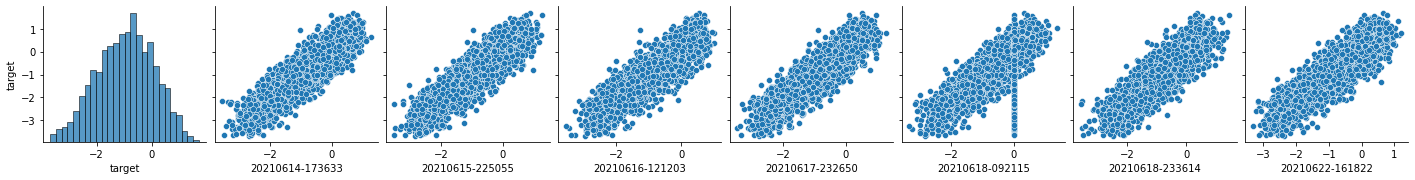

In [32]:
sns.pairplot(oofs, y_vars=["target"], x_vars=["target"] + pred_cols[::10]);

In [33]:
scores = cross_val_score(
#     LinearRegression(),
    Ridge(alpha=100),
#     KernelRidge(alpha=100, kernel="rbf"),
#     BaggingRegressor(n_estimators=100),
#     Lasso(),
    oofs[pred_cols],
    oofs["target"],
    scoring="neg_mean_squared_error",
#     cv=LeaveOneOut(),
    n_jobs=-1,
)
print(f"Best score: {np.sqrt(np.mean(-scores)):0.5f}")

Best score: 0.45284


In [34]:
# # reg = LassoCV(max_iter=5000, cv=LeaveOneOut(), n_jobs=-1)  # 0.45689
# reg = ElasticNetCV(l1_ratio=[0.01, 0.05, .1, .5, .7, .9, .95, .99, 1], max_iter=5000, n_jobs=-1, tol=1e-5)  # 0.45619

# reg.fit(oofs[pred_cols], oofs["target"])
# # print(f"Best score: {np.sqrt(reg.mse_path_[-1].mean()):0.5f}")
# print(reg.l1_ratio_)

# np.sqrt(reg.mse_path_[1, -1].mean())

# Brute force model selection

In [35]:
# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)  # allows duplicate elements
#     return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

# subsets = list(powerset(pred_cols))
# len(subsets)

In [36]:
# best_score = 10
# best_cols = None

# for s in tqdm(subsets[1:]):
#     reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
#     reg.fit(oofs[list(s)], oofs["target"])
#     score = np.sqrt(-reg.best_score_)
    
#     if score < best_score:
#         best_score = score
#         best_cols = list(s)
        
# print(f"Best score: {best_score:0.5f}")
# print("Best cols", best_cols)

In [37]:
# ['model_1', 'model_2', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_11', 'model_13', 'model_16']

# Hill climbing

In [38]:
def get_score(X, y):
    #     reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000), normalize=True)
    #     reg.fit(X, y)
    #     return np.sqrt(-reg.best_score_)
    reg = LassoCV(
        max_iter=5000,
        random_state=48,
        n_jobs=-1,
        normalize=True,
#         cv=RepeatedKFold(random_state=48),
    ).fit(X, y)
    return np.sqrt(reg.mse_path_)[-1].mean()


def averaging(X, y):
    y_pred = X.mean(1)
    return np.sqrt(mean_squared_error(y_pred, y))

In [39]:
candidates = model_folders.copy()

best_score = np.inf
selection = []
# tol = 0.00001
tol = 0
y = oofs["target"]

# Find best initial model
initial_scores = [np.sqrt(mean_squared_error(oofs[c], oofs["target"])) for c in candidates]
idx = np.argmin(initial_scores)
best_score = initial_scores[idx]
selection.append(candidates[idx])
print(f"Initial {candidates[idx]}. Score {best_score:0.5f}")
del candidates[idx]


while True:
    scores = [get_score(oofs[selection + [c]], y) for c in candidates]
#     scores = [averaging(oofs[selection + [c]], y) for c in candidates]

    idx = np.argmin(scores)
    if scores[idx] < best_score - tol:
        best_score = scores[idx]
        selection.append(candidates[idx])
        print(f"Added {candidates[idx]}. New best score {best_score:0.5f}")
        del candidates[idx]
    else:
        break
        
print(len(selection), "models selected")
        
selection

Initial 20210614-234025. Score 0.48016
Added 20210616-041221. New best score 0.46539
Added 20210617-135233. New best score 0.45897
Added 20210615-225055. New best score 0.45676
Added 20210618-030706. New best score 0.45552
Added 20210619-035747. New best score 0.45460
Added 20210614-173633. New best score 0.45343
Added 20210616-060255. New best score 0.45300
Added 20210619-004022. New best score 0.45254
Added 20210616-132341. New best score 0.45195
Added 20210617-102611. New best score 0.45151
Added 20210618-223208. New best score 0.45106
Added 20210615-094729. New best score 0.45082
Added 20210615-234038. New best score 0.45062
Added 20210618-092115. New best score 0.45047
Added 20210616-003038. New best score 0.45039
Added 20210616-075451. New best score 0.45033
Added 20210615-105329. New best score 0.45028
Added 20210617-232650. New best score 0.45023
Added 20210618-183719. New best score 0.45022
Added 20210622-152356. New best score 0.45021
21 models selected


['20210614-234025',
 '20210616-041221',
 '20210617-135233',
 '20210615-225055',
 '20210618-030706',
 '20210619-035747',
 '20210614-173633',
 '20210616-060255',
 '20210619-004022',
 '20210616-132341',
 '20210617-102611',
 '20210618-223208',
 '20210615-094729',
 '20210615-234038',
 '20210618-092115',
 '20210616-003038',
 '20210616-075451',
 '20210615-105329',
 '20210617-232650',
 '20210618-183719',
 '20210622-152356']

In [17]:
model_folders_current = [
    "20210614-234025",
    "20210616-041221",
    "20210617-135233",
    "20210615-225055",
    "20210618-030706",
    "20210614-173633",
    "20210619-035747",
    "20210617-120949",
    "20210619-004022",
    "20210616-132341",
    "20210616-060255",
    "20210618-223208",
    "20210615-094729",
    "20210615-234038",
    "20210617-102611",
    "20210619-014809",
    "20210616-075451",
    "20210618-092115",
    "20210615-054256",
    "20210615-105329",
    "20210616-003038",
#     "20210614-203831",
]

model_folders_new = [
    "20210614-234025",
    "20210616-041221",
    "20210617-135233",
    "20210615-225055",
    "20210618-030706",
    "20210619-035747",
    "20210614-173633",
    "20210616-060255",
    "20210619-004022",
    "20210616-132341",
    "20210617-102611",
    "20210618-223208",
    "20210615-094729",
    "20210615-234038",
    "20210618-092115",
    "20210616-003038",
    "20210616-075451",
    "20210615-105329",
    "20210617-232650",
#     "20210614-203831",
    "20210618-183719",
    "20210622-152356",
]

model_folders_current = set(model_folders_current)
model_folders_new = set(model_folders_new)

In [18]:
# Add these
model_folders_new.difference(model_folders_current)

{'20210617-232650', '20210618-183719', '20210622-152356'}

In [19]:
# Remove these
model_folders_current.difference(model_folders_new)

{'20210615-054256', '20210617-120949', '20210619-014809'}

# Feature selection

In [20]:
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

In [21]:
# estimator = RidgeCV(
#     alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000), normalize=True
# )
estimator = LassoCV(max_iter=5000, random_state=48, n_jobs=-1, normalize=True)

selector = SequentialFeatureSelector(
    estimator,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
selector = selector.fit(oofs[pred_cols], oofs["target"])
print(selector.n_features_to_select_)

pred_cols = np.array(pred_cols)
pred_cols[selector.support_]

35


array(['20210614-173633', '20210614-203831', '20210614-234025',
       '20210615-094729', '20210615-105329', '20210615-130640',
       '20210615-225055', '20210615-234038', '20210616-003038',
       '20210616-041221', '20210616-060255', '20210616-075451',
       '20210616-094506', '20210616-124738', '20210616-132341',
       '20210617-102611', '20210617-135233', '20210617-232650',
       '20210618-011405', '20210618-030706', '20210618-082756',
       '20210618-092115', '20210618-144213', '20210618-183719',
       '20210618-203441', '20210618-223208', '20210618-233614',
       '20210619-004022', '20210619-025421', '20210619-035747',
       '20210619-150740', '20210622-152356', '20210622-171312',
       '20210622-181238', '20210622-201127'], dtype='<U15')

In [22]:
scores = cross_val_score(
    estimator,
    oofs[pred_cols[selector.support_]],
    oofs["target"],
    scoring="neg_mean_squared_error",
    cv=LeaveOneOut(),
    n_jobs=-1,
)
print(f"Best score: {np.sqrt(np.mean(-scores)):0.5f}")

Best score: 0.45224


# GBT

In [23]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [24]:
kf = KFold(shuffle=True, random_state=48)
scores = []

for fold, (trn_idx, val_idx) in enumerate(kf.split(oofs[pred_cols], oofs["target"])):
    X_train, y_train = oofs.loc[trn_idx, pred_cols], oofs.loc[trn_idx, "target"]
    X_valid, y_valid = oofs.loc[val_idx, pred_cols], oofs.loc[val_idx, "target"]

#     reg = HistGradientBoostingRegressor(
#         learning_rate=0.01,
#         max_iter=1000,
#         max_leaf_nodes=15,
#         l2_regularization=0.0,
#         early_stopping=True,
#         n_iter_no_change=100,
#     )
#     reg = GaussianProcessRegressor(normalize_y=True, alpha=0.4)
#     reg = MLPRegressor(max_iter=20000, early_stopping=True, n_iter_no_change=100, alpha=0.001)
#     reg = SVR(kernel="linear", C=0.01, epsilon=0.001)
#     reg = TheilSenRegressor(n_jobs=-1)
    reg = RANSACRegressor(base_estimator=Ridge(alpha=50), loss="squared_loss", max_trials=1000)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_pred, y_valid))
    scores.append(score)
    print(f"Fold {fold} RMSE: {score:0.5f}")
print(f"Final RMSE: {np.mean(scores):0.5f}")

Fold 0 RMSE: 0.45051
Fold 1 RMSE: 0.45226
Fold 2 RMSE: 0.45614
Fold 3 RMSE: 0.47124
Fold 4 RMSE: 0.44248
Final RMSE: 0.45452
